In [1]:
pip install fastai2 fastdot -q

     |████████████████████████████████| 184kB 1.4MB/s 


# 03 TabNet

In this notebook we'll be looking at comparing the `TabNet` architecture to our regular `fastai` fully connected models. We'll be utilizing Michael Grankin's `fast_tabnet` wrapper to utilize the model.

In [0]:
pip install fast_tabnet -q

TabNet is an attention-based network for tabular data, originating [here](https://arxiv.org/pdf/1908.07442.pdf). Let's first look at our fastai architecture and then compare it with TabNet utilizing the `fastdot` library.

First let's build our data real quick so we know just what we're visualizing. We'll use `ADULTs` again

In [0]:
from fastai2.tabular.all import *

In [0]:
path = untar_data(URLs.ADULT_SAMPLE)
df = pd.read_csv(path/'adult.csv')

We'll build our `TabularPandas` object and the `DataLoaders`

In [0]:
cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race']
cont_names = ['age', 'fnlwgt', 'education-num']
procs = [Categorify, FillMissing, Normalize]
splits = RandomSplitter()(range_of(df))

In [0]:
to = TabularPandas(df, procs, cat_names, cont_names, y_names="salary", splits=splits)
dls = to.dataloaders(bs=1)

And let's look at one batch to understand how the data is coming into the model:

In [186]:
dls.one_batch()

(tensor([[1, 1, 1, 1, 5, 5, 1]]),
 tensor([[-0.2641, -0.2518, -1.5991]]),
 tensor([[0]], dtype=torch.int8))

So we can see first is our categoricals, second is our continuous, and the third is our `y`. With this in mind, let's make a `TabularModel` with 200 and 100 layer sizes:

In [0]:
learn = tabular_learner(dls, layers=[200,100], metrics=accuracy)

Now a basic visualization of this model can be made with `fastdot` like below:

In [0]:
from fastdot import *

## Hidden

In [0]:
layers_cat = ['Embedding Matrix', 'Dropout']
inp = ['Input']
cont_bn = ['BatchNorm1d']
lin_bn_drop = ['BatchNorm1d', 'Dropout', 'Linear', 'ReLU']
full_lin = ['LinBnDrop\n(ni, 200)', 'LinBnDrop\n(200,100)', 'LinBnDrop\n(100,2)']

In [0]:
block1, block2, block3, block4, block5 = ['Preprocessed Input', 'Categorical\nEmbeddings',
                                  'Continous\nBatch Normalization', 'Fully\nConnected Layers',
                                  'LinBnDrop']

In [0]:
conns = ((block1, block2),
         (block1, block3),
         (block2, block4),
         (block3, block4))

In [0]:
def color(o):
  if o == 'Embedding Matrix': return 'white'
  if o == 'Input': return 'gray'
  if 'Dropout' in o: return 'gold'
  if 'BatchNorm' in o: return 'pink'
  if 'Lin' in o: return 'lightblue'
  if 'ReLU' in o: return 'gray'

In [0]:
node_defaults['fillcolor'] = color

In [39]:
model = [
                seq_cluster(inp, block1),
                seq_cluster(layers_cat, block2),
                seq_cluster(cont_bn, block3),
                seq_cluster(full_lin, block4)]

fcc = seq_cluster(lin_bn_drop, block5)
g = graph_items(*model)
g.add_items(fcc)
g.add_items(*object_connections(conns))

(#4) [<pydot.Edge object at 0x7fca8ecca2b0>,<pydot.Edge object at 0x7fca8ecd3f98>,<pydot.Edge object at 0x7fca8ec796a0>,<pydot.Edge object at 0x7fca8ec92080>]

## Graph

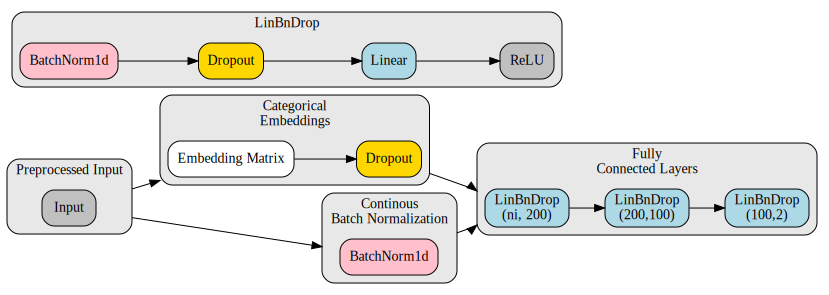

In [40]:
g

How does this compare to TabNet? This is TabNet:

## Hide

In [0]:
block1, block2, block3, block4, block5 = ['Preprocessed Input', 'Categorical\nEmbeddings',
                                  'Continous\nBatch Normalization', 'TabNet', 'Output']

In [0]:
conns = ((block1, block2),
         (block1, block3),
         (block2, block4),
         (block3, block4),
         (block4, block5))

In [0]:
feat_tfmer = [*shared, *specifics]

In [0]:
fcc = ['Linear']

In [0]:
tabnet = ['Attention\nTransformer', 'Feature\nTransformer', 'Final\nMapping (Linear)']

In [0]:
def color(o):
  if o == 'Embedding Matrix': return 'white'
  if o == 'Input': return 'gray'
  if 'Dropout' in o: return 'white'
  if 'BatchNorm' in o: return 'pink'
  if 'Att' in o: return 'lightblue'
  if 'Feat' in o: return 'darkseagreen2'
  if 'Mask' in o: return 'lightgray'
  if 'Lin' in o: return 'gold2'
  if 'Out' in o: return 'lightgray'
  return 'white'

node_defaults['fillcolor'] = color

In [0]:
def cluster_color(o):
  if 'Attention' in o: return 'lightblue'
  if 'Feat' in o: return 'darkseagreen2'
  return 'lightgray'

cluster_defaults['fillcolor'] = cluster_color

In [0]:
block1, block2, block3, block4, block5 = ['Preprocessed Input', 'Categorical\nEmbeddings',
                                  'Continous\nBatch Normalization', 'TabNet', 'Output']

In [0]:
out = ['Output', 'Mask_Loss', 'Mask_Explain', 'Masks']

In [0]:
model = [
         seq_cluster(inp, block1),
         seq_cluster(layers_cat, block2),
         seq_cluster(cont_bn, block3),
         seq_cluster(tabnet, block4),
         *Cluster(block5).add_items(*out),
         ]

In [0]:
conns = ((block1, block2),
         (block1, block3),
         (block2, block4),
         (block3, block4),
         (block4, out[0]),
         (block4, out[1]),
         (block4, out[2]),
         (block4, out[3]))

In [175]:
g = graph_items(*model)
g.add_items(*object_connections(conns))

(#8) [<pydot.Edge object at 0x7fa9d96c8400>,<pydot.Edge object at 0x7fa9d96a16a0>,<pydot.Edge object at 0x7fa9d96b3a20>,<pydot.Edge object at 0x7fa9d96af3c8>,<pydot.Edge object at 0x7fa9d96c0da0>,<pydot.Edge object at 0x7fa9d9646780>,<pydot.Edge object at 0x7fa9d96b77b8>,<pydot.Edge object at 0x7fa9d9816630>]

In [0]:
att_tfmer = ['Linear', 'GhostBatchNorm', 'torch.mul(x, prior)', 'Sparsemax']
shared = ['Linear\n(ni, 80)', 'Linear\n(ni-2, 80)']
specifics = ['GLU Block']
feat_tfmer = [*shared, *specifics]

In [0]:
att_clus = seq_cluster(att_tfmer, 'Attention Transformer')
feat_clus = seq_cluster(feat_tfmer, 'Feature Transformer')

## Graphs

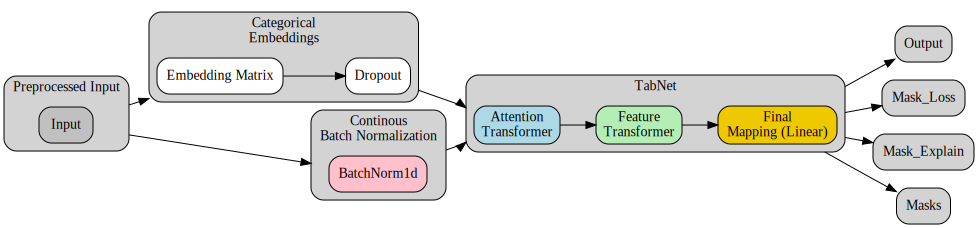

In [176]:
g

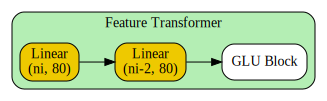

In [179]:
graph_items(feat_clus)

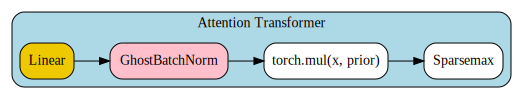

In [180]:
graph_items(att_clus)

So a few things to note, we now have two transformers, one that keeps an eye on the features and another that keeps an eye on the attention. We could call the Attention transformer the **encoder** and the Feature transformer the **decoder**. What this attention let's us do is see *exactly* how our model is behaving, moreso than just how our feature importance and other techniques "guess"

Now that we have this done, how do we make a model?

# Using TabNet

I have found in my experiments that TabNet isn't quite as good as fastai's tabular model, but as attention can be important and is a hot topic, we'll use it here. Another con of this model is it takes *many* epochs to get a decent accuracy as we will see:

In [0]:
from fast_tabnet.core import *

First we need to grab the embedding matrix sizes:

In [190]:
emb_szs = get_emb_sz(to); emb_szs

[(10, 6), (17, 8), (8, 5), (16, 8), (7, 5), (6, 4), (3, 3)]

And now we can make use of our model! There's many different values we can pass in, here's a brief summary:

* `n_d`: Dimensions of the prediction layer (usually between 4 to 64)
* `n_a`: Dimensions of the attention layer (similar to `n_d`)
* `n_steps`: Number of sucessive steps in our network (usually 3 to 10)
* `gamma`: A scalling factor for updating attention (usually between 1.0 to 2.0)
* `momentum`: Momentum in all batch normalization
* `n_independent`: Number of independant GLU layers in each block (default is 2)
* `n_shared`: Number of shared GLU layers in each block (default is 2)
* `epsilon`: Should be kept very low (avoid `log(0)`

Let's build one similar to the model we showed in the above. To do so we'll set the dimensions of the prediction layer to 8, the number of attention layer dimensions to 32, and our steps to 4:

In [0]:
class TabNetModel(Module):
    "Attention model for tabular data."
    def __init__(self, emb_szs, n_cont, out_sz, embed_p=0., y_range=None,
                 n_d=8, n_a=8,
                 n_steps=3, gamma=1.3,
                 n_independent=2, n_shared=2, epsilon=1e-15,
                 virtual_batch_size=128, momentum=0.02):
        self.embeds = nn.ModuleList([Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(embed_p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        n_emb = sum(e.embedding_dim for e in self.embeds)
        self.n_emb,self.n_cont,self.y_range = n_emb,n_cont,y_range
        self.tab_net = TabNetNoEmbeddings(n_emb + n_cont, out_sz, n_d, n_a, n_steps,
                                          gamma, n_independent, n_shared, epsilon, virtual_batch_size, momentum)

    def forward(self, x_cat, x_cont, att=False):
        if self.n_emb != 0:
            x = [e(x_cat[:,i]) for i,e in enumerate(self.embeds)]
            x = torch.cat(x, 1)
            x = self.emb_drop(x)
        if self.n_cont != 0:
            x_cont = self.bn_cont(x_cont)
            x = torch.cat([x, x_cont], 1) if self.n_emb != 0 else x_cont
        if att:
          x, m_loss, m_explain, masks = self.tab_net(x)
        x, _, _, _ = self.tab_net(x)
        if self.y_range is not None:
            x = (self.y_range[1]-self.y_range[0]) * torch.sigmoid(x) + self.y_range[0]
        if att:
          return x, m_loss, m_explain, masks
        return x

First we need to make new `DataLoaders` because we currently have a batch size of 1

In [0]:
dls = to.dataloaders(bs=1024)

Then build the model:

In [0]:
net = TabNetModel(emb_szs, len(to.cont_names), dls.c, n_d=8, n_a=32, n_steps=1); 

Finally we'll build our `Learner` and use the `ranger` optimizer:

In [0]:
learn = Learner(dls, net, CrossEntropyLossFlat(), metrics=accuracy, opt_func=ranger)

SuggestedLRs(lr_min=0.2754228591918945, lr_steep=0.17378008365631104)

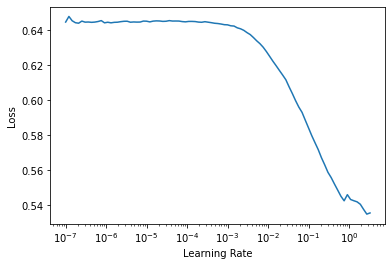

In [243]:
learn.lr_find()

In [244]:
learn.fit_flat_cos(5, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.483154,0.406819,0.814650,00:02
1,0.416817,0.376350,0.823864,00:02
2,0.388344,0.369561,0.826474,00:02
3,0.374160,0.364151,0.831542,00:02
4,0.364801,0.359283,0.836456,00:02


Now as you can see it actually didn't take that long to get to the 83% fairly quickly. On my other tests I wasn't able to do quite as well but try it out! The code is here for you to use and play with.